In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

2026-02-02 00:36:00.408097: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-02 00:36:00.449476: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-02 00:36:01.909934: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
print(tf.__version__)

2.20.0


In [3]:
batch_size = 32
img_height = 128
img_width = 128

directory = os.path.join(os.getcwd(),"data", "training")

In [4]:
training_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split = 0.2, #20% of data is used for training and validation
    subset = "training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split = 0.2, #20% of data is used for testing results
    subset = "validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 15244 files belonging to 9 classes.
Using 12196 files for training.


2026-02-02 00:36:02.766621: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 15244 files belonging to 9 classes.
Using 3048 files for validation.


In [5]:
class_names = training_ds.class_names
print(f"Categories: {class_names}")

Categories: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes']


2026-02-02 00:36:03.250592: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


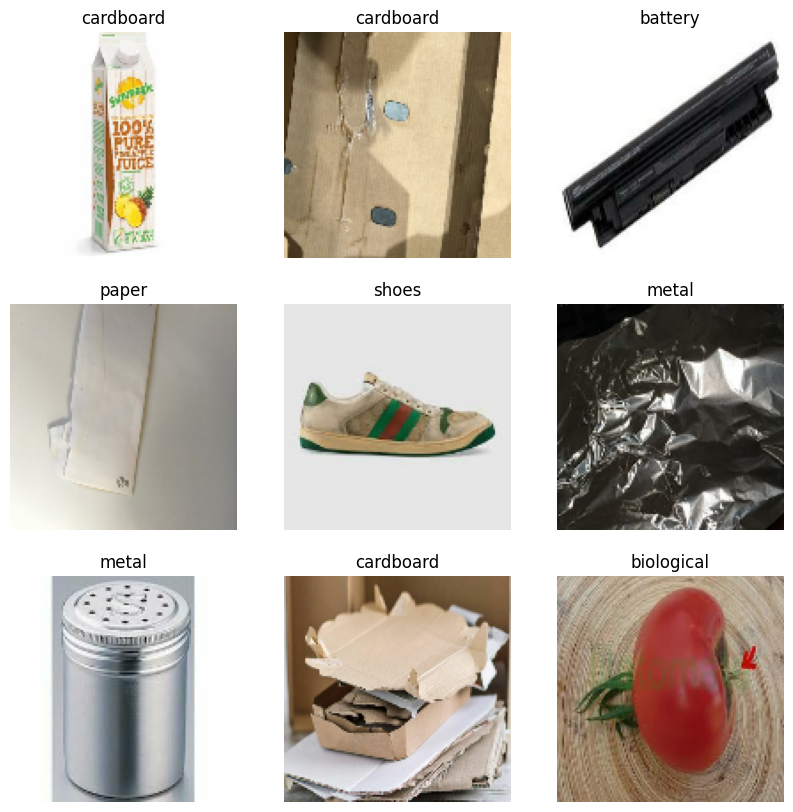

In [6]:
plt.figure(figsize=(10,10))

for images, labels in training_ds.take(1): #takes one batch of 32
    for i in range(9): 
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

In [7]:
#without augmentation the model was overfitting even getting worse on 
# validation data with loss doubling from epoch 3 to epoch 10

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

/home/cemil/NodeProjects/Sorti/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2026-02-02 00:36:03.904236: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


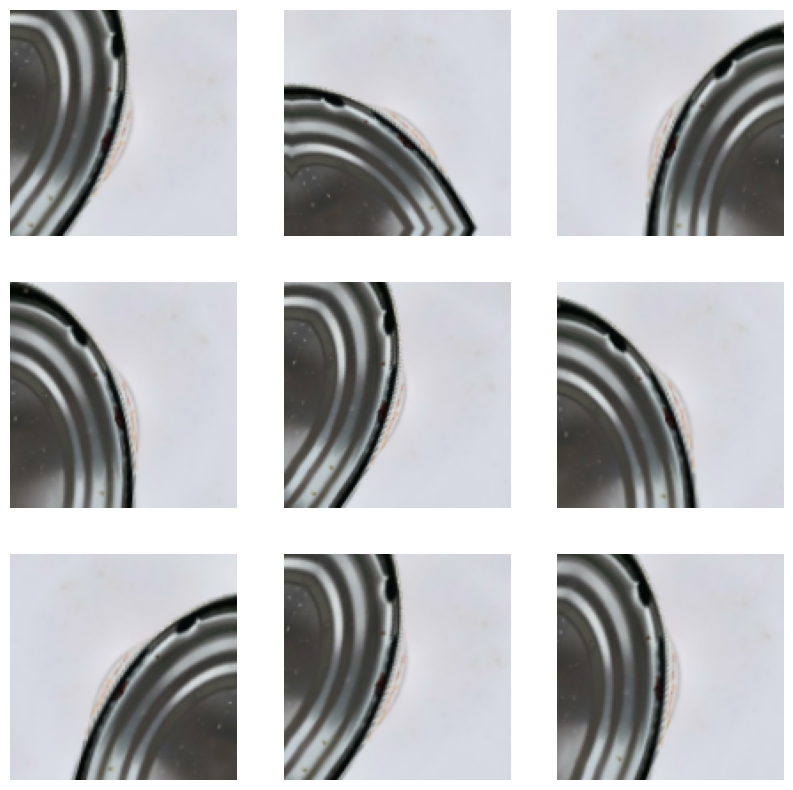

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in training_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8")) # Show 9 variations of same img
        plt.axis("off")
plt.show()

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    #layer0 makes training harder by using augmentation
    data_augmentation,

    #Layer 1: Rescaling
    tf.keras.layers.Rescaling(1./255),
    #LAyer2 : Kernel/Feature Finder
    tf.keras.layers.Conv2D(16,3, padding="same", activation="relu"),
    #Layer 3: Compressor (Shrinks feature maps from kernel)
    tf.keras.layers.MaxPooling2D(),

    #layer 4 & 5 (more filters for more complex patterns)
    tf.keras.layers.Conv2D(32,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    #lyer 6: flatten
    tf.keras.layers.Flatten(),

    #layer 7: Dense 128 Neurons("make sense" of flattened list)
    tf.keras.layers.Dense(128,activation="relu"),
    #layer 8: outputs 8 numbers (highest number is models guess)
    tf.keras.layers.Dense(num_classes)
])

model.summary()

In [ ]:
#adam is teacher that adjusts weights and biases, loss is grading scale for accuracy
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ["accuracy"]
)

In [ ]:
epochs = 40

history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Training and Validation Accuracy ({epochs} epochs)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot4(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Training and Validation Loss ({epochs} epochs)')

plt.show()

In [ ]:
# Run 4 (bigger model, added batchnormalization and more layers)

num_classes = len(class_names)

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    
    tf.keras.layers.Conv2D(32, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(128, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(256, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(512, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ["accuracy"]
)

epochs = 100
history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs
)

# 3. Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Exp 4: Deep CNN (128px) - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Exp 4: Deep CNN (128px) - Loss')
plt.show()